# Setting the OpenAI Key as an Environment Variable

In [2]:
%load_ext dotenv
%dotenv
%load_ext mypy_ipython

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv
The mypy_ipython extension is already loaded. To reload it, use:
  %reload_ext mypy_ipython


# Importing Relevant Classes and functions

In [3]:
# Library Import
from langgraph.graph import START, END, StateGraph, add_messages
from typing_extensions import TypedDict
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from typing import Optional

In [4]:
# Define State 
class SQLState(TypedDict):
    user_question: Optional[str]

    business_intent: Optional[str]
    metrics: Optional[str]
    filters: Optional[str]

    schema_context: Optional[str]
    generated_sql: Optional[str]

    another_question: Optional[str]

    no_of_queries: int

In [5]:
# Define Chat Model
chat = ChatOpenAI(model='gpt-4',
                  seed= 25,
                  max_completion_tokens= 300,
                  temperature=0
)

In [6]:
# ask_query node
def ask_query(state: SQLState) -> dict:
    print('Enter your query')
    question = input()

    return {'user_question': question}

In [7]:
# intent_extractor node
def intent_extractor(state: SQLState) -> dict:
    prompt = f'''
    Extract the business intent, metrics and filter from the below user quesion:

    Question:
    {state['user_question']}

    return in below JSON format
    {{
        "business_intent": "...."
        "metrics": [.....]
        "filters": "...."
    '''
    
    AI_response = chat.invoke([
        SystemMessage(content="You are a business analytics expert"),
        HumanMessage(content=prompt)
    ])

    data = eval(AI_response.content)

    return data

In [8]:
# schema defination node
def schema_content(state: SQLState) -> dict:
    schema = '''
    Table: Sales
    Columns:
    1. order_id (int)
    2. order_date (date)
    3. region (string)
    4. revenue (float)
    '''

    return {'schema_context': schema}

In [9]:
# generate_sql node
def generate_sql(state: SQLState) -> dict:
    sql_prompt = f'''
    You are a SQL Expert.

    Schema:
    {state['schema_context']}

    Business Intent: 
    {state['business_intent']}
    
    Metrics:
    {state['metrics']}
    
    Filters: 
    {state['filters']}

    Rules:
    - Use SELECT only
    - No DELETE / UPDATE / DROP
    - Use explicit column names

    Generate SQL only.
    '''

    generated_sql_response = chat.invoke([
        SystemMessage(content='Generate an optimised SQL query'),
        HumanMessage(content=sql_prompt)
    ])

    query = state['no_of_queries'] + 1
    
    return {
        'generated_sql': generated_sql_response.content.strip(),
        'no_of_queries': query
    }
    

In [25]:
# show_state node
def show_state(state: SQLState) -> None:
    show_state = f'''
    User Question"
    {state['user_question']}
    
    Generated_SQL:
    {state['generated_sql']}

    No. of Query Count:
    {state['no_of_queries']}
    '''
    print(show_state)

In [11]:
# ask_another_query node
def ask_another_query(state: SQLState) -> dict:
    print("Would you like to enter another query (yes/no)")
    humanResponse = input().lower()

    return {'another_question': humanResponse}

In [19]:
# Routing function
def routing_function(state: SQLState) -> str:
    another_query = state['another_question']
    query_limit = state['no_of_queries']
    if another_query == 'yes' and query_limit < 2:
        return 'True'
    else:
        print('You choose to exit or you exceeded the number of queries')
        return 'False'

In [23]:
# Graph creation
graph = StateGraph(SQLState)
graph.add_node('intent_extractor', intent_extractor)
graph.add_node('schema_content', schema_content)
graph.add_node('generate_sql', generate_sql)
graph.add_node('show_state', show_state)
graph.add_node('ask_query', ask_query)
graph.add_node('ask_another_query', ask_another_query)

graph.add_edge(START, 'schema_content')
graph.add_edge('schema_content', 'ask_query')
graph.add_edge('ask_query', 'intent_extractor')
graph.add_edge('intent_extractor', 'generate_sql')
graph.add_edge('generate_sql', 'show_state')
graph.add_edge('show_state', 'ask_another_query')
graph.add_conditional_edges(source='ask_another_query', path=routing_function, path_map={
    'True': 'ask_query',
    'False': '__end__'
})

graph_compiled = graph.compile()

In [24]:
response = graph_compiled.invoke({
    # "user_question": "Show monthly revenue for last quarter",
    "no_of_queries": 0,
})


Enter your query


 Show monthly revenue for last quarter


================================ Human Message =================================

Show monthly revenue for last quarter
================================== Ai Message ==================================

Here is the SQL query:

```sql
SELECT 
    EXTRACT(YEAR FROM order_date) AS Year,
    EXTRACT(MONTH FROM order_date) AS Month,
    SUM(revenue) AS Monthly_Revenue
FROM 
    Sales
WHERE 
    order_date >= DATE_TRUNC('quarter', CURRENT_DATE) - INTERVAL '1 quarter'
    AND order_date < DATE_TRUNC('quarter', CURRENT_DATE)
GROUP BY 
    Year, Month
ORDER BY 
    Year, Month;
```

This query will return the monthly revenue for the last quarter. The `EXTRACT` function is used to get the year and month from the `order_date`. The `SUM` function is used to calculate the total revenue for each month. The `WHERE` clause filters the data for the last quarter. The `GROUP BY` clause groups the data by year and month. The `ORDER BY` clause sorts the result by year and month.
============================

 no


You choose to exit or you exceeded the number of queries


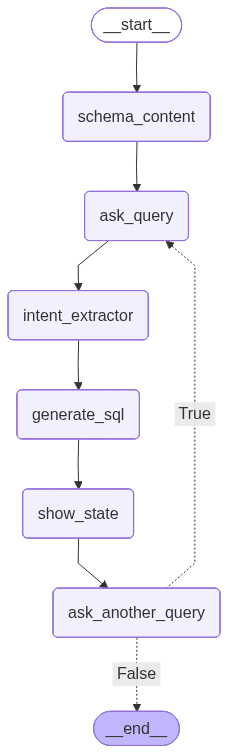

In [26]:
graph_compiled